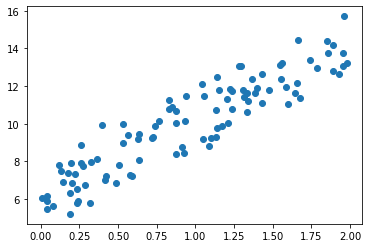

In [2]:
'''
I. 회귀소개
    - 선형회귀의 모델은 과적합 문제를 해결하기 위해 회귀 계수에 패널티 값을 적용하는 '규제' 여부에 따라
        일반 선형 회귀 : RSS 최소화, 규제 X
        릿지 : 선형 회귀에 L2 규제 추가 ; L2규제는 상대적으로 큰 회귀 계수 값의 예측 영향도를 감소시키기 위해 회귀 계수값을 더 작게 만드는 규제 모델
        라쏘 : 선형회귀에 L1 규제 추가 ; L1규제(=피처 선택 기능)는 예측 영향력이 작은 회귀 계수를 0으로 만들어 회귀 예측시 피처가 선택되지 않게 하는 것
        엘라스틱넷 : 선형회귀에 L2 + L1 규제 추가
        로지스틱 회귀 : 선형 회귀를 통한 분류 기능

II. 단순 선형 회귀를 통한 회귀 이해
    - (MAE 대신 미분이 가능한) RSS를 최소로 하는 회귀계수를 찾음; 머신러닝에서 RSS는 w 변수로 구성되는 비용함수
    
III. 비용 최소화하기 - 경사하강법 소개
'''
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(0)
#y = 4X + 6
X = 2 * np.random.rand(100,1)
y = 6 + 4*X + np.random.randn(100,1)

#시각화
plt.scatter(X,y)

w1 : 4.021813642697164, w0 : 6.162031224717461
Cost : 0.9934784315632568


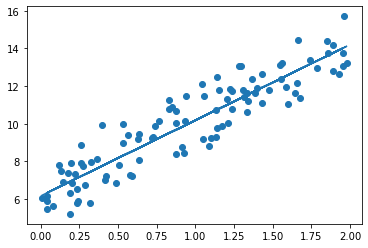

In [6]:
# 비용함수 정의
def get_cost(y,y_pred):
    N = len(y)
    cost = np.sum(np.square(y-y_pred))/N
    return cost

def get_weight_updates(w1,w0,X,y,learning_rate=0.01):
    N = len(y)
    #w1_update, w0_update를 초기화
    w1_update = np.zeros_like(w1)
    w0_update = np.zeros_like(w0)
    y_pred = np.dot(X, w1.T) + w0
    diff = y - y_pred
    
    w0_factors = np.ones((N,1))
    w1_update = -(2/N)*learning_rate*(np.dot(X.T, diff)) # ∂(1/N)*RSS/∂w1 * learning_rate
    w0_update = -(2/N)*learning_rate*(np.dot(w0_factors.T, diff)) # ∂(1/N)*RSS/∂w2 * learning_rate
    
    return w1_update, w0_update
    
def gradient_descent_steps(X,y, iters=10000):
    #w0, w1를 초기화
    w0 = np.zeros((1,1))
    w1 = np.zeros((1,1))
    
    #iters만큼 업데이트 수행
    for ind in range(iters):
        w1_update, w0_update = get_weight_updates(w1,w0,X,y,learning_rate=0.01)
        w1 = w1 - w1_update
        w0 = w0 - w0_update
    
    return w1, w0

#w1과 w0를 구해보면
w1, w0 = gradient_descent_steps(X,y,iters=1000)
print('w1 : {}, w0 : {}'.format(w1[0,0],w0[0,0]))
y_pred = w1[0,0] * X + w0
print('Cost :',get_cost(y,y_pred))

plt.scatter(X,y)
plt.plot(X, y_pred)

In [7]:
# 시간이 많이 걸리는 경사하강법 대신 (미니배치) 확률적 경사하강법을 구현해보면
def stochastic_gradient_descent_steps(X,y,batch_size=10,iters=1000):
    w0 = np.zeros((1,1))
    w1 = np.zeros((1,1))
    
    prev_cost = 100000
    iter_index=0
    
    for ind in range(iters):
        np.random.seed(ind)
        # 전체 X,y 데이터에서 랜덤하게 batch_size만큼 데이터를 추출해 이를 기반으로 w1_update, w0_update를 계산한다는 점에서 경사하강법과 차이
        stochastic_random_index = np.random.permutation(X.shape[0])
        sample_X = X[stochastic_random_index[0:batch_size]]
        sample_y = y[stochastic_random_index[0:batch_size]]
        #w1_update, w0_update 계산 후 업데이터
        w1_update, w0_update = get_weight_updates(w1,w0,sample_X,sample_y, learning_rate=0.01)
        w1 = w1 - w1_update
        w0 = w0 - w0_update
        
    return w1, w0

# w1, w0 및 예측 오류 비용 계산
w1, w0 = stochastic_gradient_descent_steps(X,y,batch_size=10, iters=1000)
print('w1 :', round(w1[0,0],3), 'w0 :', round(w0[0,0],3))
y_pred = w1[0,0] * X + w0
print('Cost :', get_cost(y,y_pred))

w1 : 4.028 w0 : 6.156
Cost : 0.9937111256675345


In [25]:
'''
IV. 사이킷런 LinearRegression을 이용한 보스턴 주택 가격 예측
    - http://scikit-learn.org/stable/modules/classes.html#module-skelarn.linear-model에서 사이킷런이 지원하는 다양한 선형 모듈 확인
    
    1. LinearRegression 클래스 - Ordinary Least Squares
        - fit() 메서드로 X,y 배열을 입력 받으면 회귀계수를 coef_ 속성에 저장(intercept는 intercept_ 속성에 저장) ; 인자는 shift+tab으로 기본적으로 볼 수 있음
        - LienarRegression(fit_intercept = True, normalize = False, copy_X = True, n_jobs=1)
        
    2. 회귀 평가 지표
        - MAE ; metrics.mean_absolute_error ; scoring 함수 적용 값: 'neg_mean_absolute_error' (negative를 붙여서 값이 커질수록 좋은 방향으로 값을 수정)
        - MSE ; 로그를 적용하면 MSLE ; metrics.eman_squared_error ; 'neg_mean_squared_error' ; sqrt(∑(Yi - Y^)^2)
        - RMSE : MSE의 root, 사이킷런에서는 MSE에 root를 씌워서 직접 구해야 함 ; 로그를 적용하면 RMSLE
        - R2 ; metrocs.r2_score ; 'r2'
    
    3. LinaerRegression을 이용해 보스턴 주택 가격 회귀 구현
'''

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_boston
from scipy import stats

%matplotlib inline

boston = load_boston()

bostonDF = pd.DataFrame(boston.data, columns = boston.feature_names)

bostonDF['PRICE'] = boston.target
print(bostonDF.shape)
bostonDF.head()


(506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


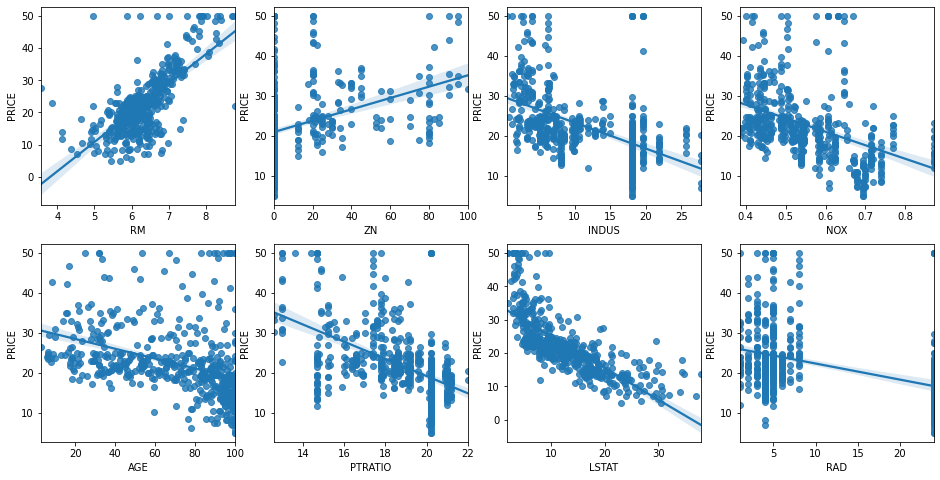

In [17]:
# 회귀선을 함께 그려주는 시본 regplot()을 통해 각 피처와 레이블의 관계를 시각화
fig, axs = plt.subplots(figsize=(16,8), ncols=4, nrows=2)
lm_features = ['RM','ZN','INDUS','NOX','AGE','PTRATIO','LSTAT','RAD']
for i, feature in enumerate(lm_features):
    row = int(i/4)
    col = i%4
    sns.regplot(x=feature, y = 'PRICE', data=bostonDF, ax=axs[row][col])

In [26]:
# RM(방개수)와 양의 상관성, LSTAT(하위 계층 비율)과 음의 상관성이 두드러짐
# LinearRegression 클래스를 이용해 회귀모델을 만들어 보면

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'], axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size=0.2)

#선형 회귀 OLS로 학습/예측/평가
lr = LinearRegression()
lr.fit(X_train, y_train)
y_preds = lr.predict(X_test)
mse = mean_squared_error(y_test, y_preds)


NameError: name 'y_tet' is not defined

In [27]:
r2 = r2_score(y_test, y_preds)

print('MSE : {}, RMSE : {}, R2 : {}'.format(mse, np.sqrt(mse), r2))


MSE : 23.406492512564057, RMSE : 4.838025683330345, R2 : 0.742584339672573


In [31]:
# 절편값과 회귀계수 확인
print('절펀 :', lr.intercept_)
print('회귀 계수 :', np.round(lr.coef_,1))

절펀 : 38.92127283718817
회귀 계수 : [ -0.1   0.    0.    3.2 -18.7   3.5   0.   -1.5   0.3  -0.   -1.    0.
  -0.6]


In [32]:
#회귀 계수를 큰 값 순으로 정렬하기 위해 Series로 생성
coeff = pd.Series(data = np.round(lr.coef_, 1), index = X_data.columns)
coeff.sort_values(ascending=False)

RM          3.5
CHAS        3.2
RAD         0.3
B           0.0
TAX        -0.0
AGE         0.0
INDUS       0.0
ZN          0.0
CRIM       -0.1
LSTAT      -0.6
PTRATIO    -1.0
DIS        -1.5
NOX       -18.7
dtype: float64

In [35]:
# 교차 검증으로 MSE와 RMSE를 측정해보면
from sklearn.model_selection import cross_val_score

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'], axis=1, inplace=False)
lr = LinearRegression()

# cross_val_score()로 5폴드 세트로 MSE 구한 뒤 이를 기반으로 다시 RMSE 구함
neg_mse_scores = cross_val_score(lr, X_data, y_target, scoring='neg_mean_squared_error', cv=5)
rmse_scores = np.sqrt(-1 * neg_mse_scores) #양수로 변환
avg_rmse = np.mean(rmse_scores)

print('5 folds의 개별 Negative MSE :', np.round(neg_mse_scores,2))
print('5 folds의 개별 RSME :', np.round(rmse_scores,2))
print('5 fold의 평균 RMSE ', avg_rmse)

5 folds의 개별 Negative MSE : [-12.46 -26.05 -33.07 -80.76 -33.31]
5 folds의 개별 RSME : [3.53 5.1  5.75 8.99 5.77]
5 fold의 평균 RMSE  5.828658946215832


In [38]:
'''
V. 다항 회귀와 과대적합/과소적합 이해
    1. 다항회귀 이해
        - 회귀가 독립변수의 단항식이 아닌 다항식으로 표현 ; y = w0 + w1x1 + w2x2 + w3x1x2 + w4x1^2 + x5x2^2
        - 다항회귀는 선형회귀의 일종(비선형회귀는 계수에 대해 비선형일때만)
        - PolynomialFeatures 클래스를 통해 피처를 다항식 피처로 변환 후 선형 회귀 수행
'''
# 단항값 [x1,x2] 를 2차 다항값 [x1,x2,x1^2,x2^2,x1x2] 로 변환해보면
from sklearn.preprocessing import PolynomialFeatures
import numpy as np

# 다항식으로 변환한 단항식 생성, [[0,1],[2,3]] 의 2x2 행렬 생성
X = np.arange(4).reshape(2,2)
print('일차 단항식 계수 피처 :\n', X)

# degree = 2인 2차 다항식으로 변환
poly = PolynomialFeatures(degree=2)
poly.fit(X)
poly_ftr = poly.transform(X)
print('변환된 2차 다항식 계수 피처 :\n', poly_ftr)
# 1행은 x1 = 0, x2 = 1 -> [1, x1, x2, x1^2, x1x2, x2^2] = [1, 0, 1, 0, 0, 1]
# 2행은 x1 = 2, x2 = 3 -> [1, x1, x2, x1^2, x1x2, x2^2] = [1, 2, 3, 4, 6, 9]

일차 단항식 계수 피처 :
 [[0 1]
 [2 3]]
변환된 2차 다항식 계수 피처 :
 [[1. 0. 1. 0. 0. 1.]
 [1. 2. 3. 4. 6. 9.]]


In [47]:
# 3차 다항회귀 함수식을 추정

# y = 1 + 2x1 + 3x1^2 + 4x2^3 로 설정
def polynomial_func(X):
    y = 1 + 2*X[:,0] + 3*X[:,0]**2 + 4*X[:,1]**3 # [;, 0] 이런식의 슬라이싱은 ndarray에서 가능(0열의 모든 값)
    return y

X = np.arange(4).reshape(2,2)
print(X)
y = polynomial_func(X)
print(y)

[[0 1]
 [2 3]]
[  5 125]


In [49]:
# 다항 회귀 구현
# 3차 다항식 변환
poly_ftr = PolynomialFeatures(degree=3).fit_transform(X)
print(poly_ftr)

# Linear Regression 학습
model = LinearRegression()
model.fit(poly_ftr,y)
print('회귀 계수 :', np.round(model.coef_,2))
print('회귀 shape', model.coef_.shape)
# 원래 회귀계수인 [1,2,0,3,0,0,0,0,0,4] 와는 차이가 있지만 근사하고 있음

[[ 1.  0.  1.  0.  0.  1.  0.  0.  0.  1.]
 [ 1.  2.  3.  4.  6.  9.  8. 12. 18. 27.]]
회귀 계수 : [0.   0.18 0.18 0.36 0.54 0.72 0.72 1.08 1.62 2.34]
회귀 shape (10,)


In [50]:
# 사이킷런의 Pipeline 객체를 이용해 다항회귀를 한번에 구현
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline 
import numpy as np

def polynomial_func(X):
    y = 1 + 2*X[:,0] + 3*X[:,0]**2 + 4*X[:,1]**3 # [;, 0] 이런식의 슬라이싱은 ndarray에서 가능(0열의 모든 값)
    return y

# Pipeline 객체로 Streamline하게 Polynomial FEature 변환과 선형회귀를 연결
model = Pipeline([('poly', PolynomialFeatures(degree=3)), ('linear', LinearRegression())])
X = np.arange(4).reshape(2,2)
y = polynomial_func(X)

model = model.fit(X,y)
print('다항회귀 계수 :', np.round(model.named_steps['linear'].coef_,2))

다항회귀 계수 : [0.   0.18 0.18 0.36 0.54 0.72 0.72 1.08 1.62 2.34]



Dgree 1 회귀 계수는 [-1.61]입니다.
Degree 1 MSE는 0.40772896250986845 입니다

Dgree 4 회귀 계수는 [  0.47 -17.79  23.59  -7.26]입니다.
Degree 4 MSE는 0.043208749872317556 입니다

Dgree 15 회귀 계수는 [-2.98295000e+03  1.03900050e+05 -1.87417308e+06  2.03717524e+07
 -1.44874234e+08  7.09320168e+08 -2.47067524e+09  6.24565587e+09
 -1.15677381e+10  1.56896159e+10 -1.54007266e+10  1.06458152e+10
 -4.91381762e+09  1.35920853e+09 -1.70382347e+08]입니다.
Degree 15 MSE는 181777900.10696036 입니다


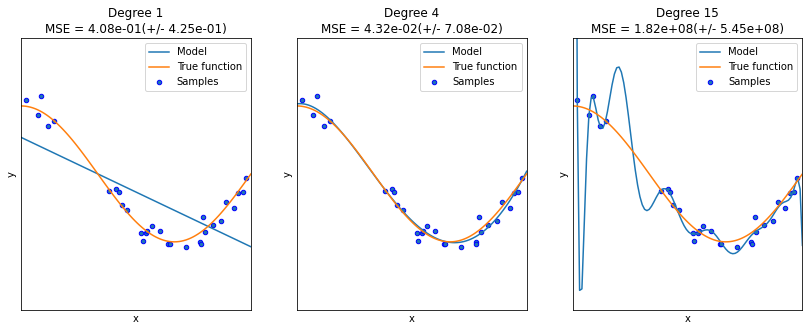

In [52]:
'''
    2. 다항 회귀를 이용한 과소/과대적합 이해
        - 차수가 높아질 수록 과적합 문제가 크게 발생
        - 과적합 문제를 잘 보여주는 http://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html#sphx-glr-quto-examples-model-selection-plot-underfitting-overfitting-py
        - 해당 코드는 X와 y가 잡음이 포함된 다항식의 코사인 그래프 관계를 가지도록 만들어줌
'''
# 임의의 값으로 구성된 X값에 대해 코사인 변환값을 반환
def true_fun(X):
    return np.cos(1.5 * np.pi * X)

# X는 0부터 1까지 30개의 임의의 값을 순서대로 샘플랭
np.random.seed(0)
n_samples = 30
degrees = [1, 4, 15]

# y 값은 코사인 기반 + 노이즈
X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.1

plt.figure(figsize=(14, 5))
degrees = [1,4,15]

# 다항 회귀 차수를 1,4,15로 각각 변화시키면서 비교
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())
    
    # 개별 degree별로 polynomial 변환
    polynomial_features = PolynomialFeatures(degree=degrees[i],
                                             include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    pipeline.fit(X[:, np.newaxis], y)

    # 교차 검증으로 다항 회귀 평가
    scores = cross_val_score(pipeline, X[:, np.newaxis], y, scoring="neg_mean_squared_error", cv=10)
    #Pipeline을 구성하는 세부 객체를 접근하는 named_steps['객체명']을 이용해 회귀계수 추출
    coefficients = pipeline.named_steps['linear_regression'].coef_
    print('\nDgree {} 회귀 계수는 {}입니다.'.format(degrees[i], np.round(coefficients, 2)))
    print('Degree {} MSE는 {} 입니다'.format(degrees[i], -1*np.mean(scores)))
    
    # 0부터 1까지 테스트 데이터를 100개로 나눠 예측 수행
    # 테스트 데이터 세트에 회귀 예측을 수행하고 예측 곡선과 실제 곡서을 그려서 비교
    X_test = np.linspace(0, 1, 100)
    #예측값 곡선
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    #실제값 곡선
    plt.plot(X_test, true_fun(X_test), label="True function")
    plt.scatter(X, y, edgecolor='b', s=20, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")
    plt.title("Degree {}\nMSE = {:.2e}(+/- {:.2e})".format(
        degrees[i], -scores.mean(), scores.std()))
plt.show()
#차례대로 과소적합, 균형잡힌모델, 과대적합(샘플데이터만 정확히 측정하고 테스트 데이터는 예측 X)

In [56]:
'''
    3. 편향-분산 트레이드오프
        - 위의 Degree1(과소적합모델) : 매우 단순화된 모델로 한방향에 치우친 고현향성을 가짐 ; Degree15(과대적합모델) : 매우 복잡한 모델 고분산성 가짐
        - 저분산 저편향 : 가운데 밀집된 과녁
          저분산 고편향 : 다른 방향으로 밀집된 과녁
          고분산 저편향 : 가운데로 넓게 퍼진 과녁
          고분산 고편향 : 다른 방향으로 넓게 퍼진 과녁
        - 일반적으로 편향과 분산은 트레이드오프 관계

VI. 규제 선형 모델 - 릿지, 라쏘, 엘라스틱넷
    1. 규제 선형 모델의 개요
        - RSS 최소화 방법과 과적합을 방지하기 위해 회귀 계수 값이 커지지 않도록 하는 방법이 균형이 이루도록 규제
        - 비용 함수 목표 = Min [ RSS(w) + alpha * ||W||(2)_2], alpha는 학습 데이터 적합 정도와 회귀 계수 값의 크기 제어를 수행하는 튜닝 파라미터(0이면 기존 파라미터, 무한대면 W를 0에 가깝게 해야됨) 
        - L2 규제는 ||W||(2)_2 와 같이 W 제곱에 대해 패널티를 부여하는 방식 -> 릿지 회귀
        - L1 규제는 ||W||_1와 같이 W의 절대값에 대해 패널티를 부여, 영향력이 크지 않은 회귀 계수 값을 0으로 변환 -> 라쏘 방식

    2. 릿지 회귀
        - Ridge 클래스 이용
'''
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

# alpha = 10으로 설정, 릿지회귀 수행
ridge = Ridge(alpha = 10)
neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring='neg_mean_squared_error', cv=5)
rmse_scores = np.sqrt(-1*neg_mse_scores)
avg_rmse=np.mean(rmse_scores)
print(avg_rmse)


5.518166280868971


In [59]:
# alpha값 변화에 따른 RMSE 변화 확인
alphas = [0, 0.1, 1, 10, 100]
for alpha in alphas :
    ridge = Ridge(alpha = alpha)
    neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring = 'neg_mean_squared_error', cv=5)
    avg_rmse = np.mean(np.sqrt(-1*neg_mse_scores))
    print('alpha {}, RMSE {}'.format(alpha, avg_rmse))

alpha 0, RMSE 5.828658946215806
alpha 0.1, RMSE 5.788486627032413
alpha 1, RMSE 5.6525709656135446
alpha 10, RMSE 5.518166280868971
alpha 100, RMSE 5.329589628472147


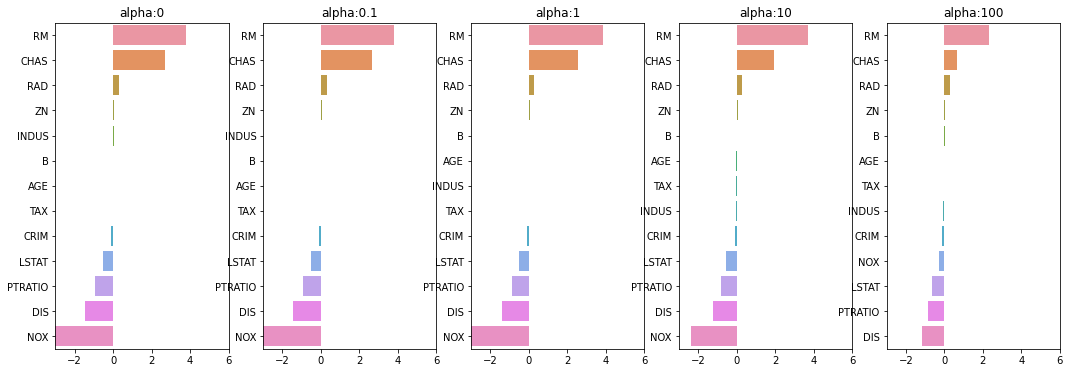

In [66]:
# alpha값 변화에 따른 피처의 회귀 계수 값을 시각화

# 맷플롯립 축 생성
fig, axs = plt.subplots(figsize=(18,6), nrows=1, ncols=5)
# coefficient를 저장할 DataFrame 생성
coeff_df = pd.DataFrame()

for pos, alpha  in enumerate(alphas):
    ridge = Ridge(alpha = alpha)
    ridge.fit(X_data, y_target)
    # alpha에 따른 회귀 계수를 시리즈로 반환, dataframe에 추가
    coeff = pd.Series(data=ridge.coef_, index = X_data.columns)
    colname = 'alpha:'+str(alpha)
    coeff_df[colname] = coeff
    # 막대 그래프로 회귀 계수 높은 순으로 표현
    coeff = coeff.sort_values(ascending=False)
    axs[pos].set_title(colname)
    axs[pos].set_xlim(-3,6)
    sns.barplot(x=coeff.values, y=coeff.index, ax=axs[pos])
    
plt.show()

In [73]:
ridge_alphas = [0, 0.1, 1, 10, 100]
sort_column = 'alpha:'+str(ridge_alphas[0])
coeff_df.sort_values(by=sort_column,ascending=False)

,alpha:0,alpha:0.1,alpha:1,alpha:10,alpha:100
RM,3.809865,3.818233,3.854000,3.702272,2.334536
CHAS,2.686734,2.670019,2.552393,1.952021,0.638335
RAD,0.306049,0.303515,0.290142,0.279596,0.315358
ZN,0.046420,0.046572,0.047443,0.049579,0.054496
INDUS,0.020559,0.015999,-0.008805,-0.042962,-0.052826
B,0.009312,0.009368,0.009673,0.010037,0.009393
AGE,0.000692,-0.000269,-0.005415,-0.010707,0.001212
TAX,-0.012335,-0.012421,-0.012912,-0.013993,-0.015856
CRIM,-0.108011,-0.107474,-0.104595,-0.101435,-0.102202
LSTAT,-0.524758,-0.525966,-0.533343,-0.559366,-0.660764


In [15]:
'''
    3. 라쏘회귀
        - W의 절대값에 패널티를 부여하는 L1규제 적용 : RSS(w) + alpha* ||W||_1를 최소화
        - L1 규제는 불필요한 회귀계수를 급격하게 감소시켜 0으로 만들고 제거
        - 사이킷런에서는 Lasso 클래스를 이용해 구현
'''
from sklearn.linear_model import Ridge, Lasso, ElasticNet
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score


# alpha값에 따른 회귀 모델의 폴드 평균 RMSE를 출력하고 회귀계수값을 DataFrame으로 반환하는 함수 생성
def get_linear_reg_eval(model_name, params=None, X_data_n = None, y_target_n = None, verbose=True):
    coeff_df = pd.DataFrame()
    if verbose : print('####', model_name,'####')
    for param in params:
        if model_name =='Ridge': model = Ridge(alpha=param)
        elif model_name == 'Lasso':model = Lasso(alpha=param)
        elif model_name == 'ElasticNet':model= ElasticNet(alpha=param, l1_ratio=0.7)
        neg_mse_scores = cross_val_score(model, X_data_n, y_target_n, scoring='neg_mean_squared_error', cv=5)
        avg_rmse = np.mean(np.sqrt(-1*neg_mse_scores))
        print('alpha {}일 때 5폴드 세트 평균 RMSE : {:.3f}'.format(param, avg_rmse))
        model.fit(X_data, y_target)
        coeff = pd.Series(data=model.coef_,index=X_data.columns)
        colname='alpha:'+str(param)
        coeff_df[colname]=coeff
    return coeff_df


In [18]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
boston = load_boston()
bostonDF = pd.DataFrame(boston.data, columns = boston.feature_names)
bostonDF['PRICE'] = boston.target
y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'], axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size=0.2)


lasso_alphas=[0.07,0.1,0.5,1,3]
coeff_lasso_df = get_linear_reg_eval('Lasso',params=lasso_alphas,X_data_n=X_data, y_target_n=y_target)

#### Lasso ####
alpha 0.07일 때 5폴드 세트 평균 RMSE : 5.612
alpha 0.1일 때 5폴드 세트 평균 RMSE : 5.615
alpha 0.5일 때 5폴드 세트 평균 RMSE : 5.669
alpha 1일 때 5폴드 세트 평균 RMSE : 5.776
alpha 3일 때 5폴드 세트 평균 RMSE : 6.189


In [22]:
# alpha에 따른 피처별 회귀계수
sort_column = 'alpha:'+str(lasso_alphas[0])
coeff_lasso_df.sort_values(by=sort_column, ascending=False) # 일부 피처의 회귀계수가 0으로 바뀌었음을 확인

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
RM,3.789725,3.703202,2.498212,0.949811,0.000000
CHAS,1.434343,0.955190,0.000000,0.000000,0.000000
RAD,0.270936,0.274707,0.277451,0.264206,0.061864
ZN,0.049059,0.049211,0.049544,0.049165,0.037231
B,0.010248,0.010249,0.009469,0.008247,0.006510
NOX,-0.000000,-0.000000,-0.000000,-0.000000,0.000000
AGE,-0.011706,-0.010037,0.003604,0.020910,0.042495
TAX,-0.014290,-0.014570,-0.015442,-0.015212,-0.008602
INDUS,-0.042120,-0.036619,-0.005253,-0.000000,-0.000000
CRIM,-0.098193,-0.097894,-0.083289,-0.063437,-0.000000


In [23]:
'''
    4. 엘라스틱넷 회귀
        - L2규제와 L1규제는 결합 : RSS(W) + alpha2*||W||_(2)_2 + alpha1*||W||_1를 최소화
        - 라쏘회귀가 서로 상관관계가 높은 피처들의 경우 이들 중에서 중요 피처만 선택 후 나머지는 0으로 만드는 성향이 강하기 때문에 이를 중화하기 위해 L2규제를 추가
        - ElasticNet 클래스 이용, 파라미터는 alpha와 l1_ratio가 있는데 각각 alpha = alpha1 + alhpa2, l1_ratio = alpha1/(alpha1 + alpha2) 를 의미
'''
# 엘라스틱넷에 사용될 alpha 파라미터의 값들을 정의후 get_linear_reg_eval() 호출
# l1_raio = 0.7로 고정
elastic_alphas=[0.07, 0.1, 0.5, 1,3]
coeff_elastic_df = get_linear_reg_eval('ElasticNet', params=elastic_alphas, X_data_n = X_data, y_target_n = y_target)

#### ElasticNet ####
alpha 0.07일 때 5폴드 세트 평균 RMSE : 5.542
alpha 0.1일 때 5폴드 세트 평균 RMSE : 5.526
alpha 0.5일 때 5폴드 세트 평균 RMSE : 5.467
alpha 1일 때 5폴드 세트 평균 RMSE : 5.597
alpha 3일 때 5폴드 세트 평균 RMSE : 6.068


In [24]:
# 데이터 프레임으로 표현
coeff_elastic_df.sort_values(by='alpha:0.07', ascending=False)

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
RM,3.574162,3.414154,1.918419,0.938789,0.000000
CHAS,1.330724,0.979706,0.000000,0.000000,0.000000
RAD,0.278880,0.283443,0.300761,0.289299,0.146846
ZN,0.050107,0.050617,0.052878,0.052136,0.038268
B,0.010122,0.010067,0.009114,0.008320,0.007020
AGE,-0.010116,-0.008276,0.007760,0.020348,0.043446
TAX,-0.014522,-0.014814,-0.016046,-0.016218,-0.011417
INDUS,-0.044855,-0.042719,-0.023252,-0.000000,-0.000000
CRIM,-0.099468,-0.099213,-0.089070,-0.073577,-0.019058
NOX,-0.175072,-0.000000,-0.000000,-0.000000,-0.000000


In [30]:
'''
    5. 선형회귀모델을 위한 데이터 변환
        - 타깃과 피처는 정규분포일수록 좋음 -> 왜곡이 심한 데이터의 경우 분석전 스케일링/정규화 작업을 수행하는 것이 일반적
          (i) StandardScaler, MinMaxScaler 이용
          (ii) (i)이 효과가 없을시 다항변환
          (iii) log transformation -> 가장 일반적으로 이용, 효과가 좋음
        - 타깃의 경우 특히 로그변환이 효과가 좋음(왜곡이 크게 감소되는 경향)
'''

# 데이터 변환 함수 생성
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
def get_scaled_data(method=None, p_degree=None, input_data=None):
    if method == 'Standard':
        scaled_data = StandardScaler().fit_transform(input_data)
    elif method == 'MinMax':
        scaled_data = MinMaxScaler().fit_transform(input_data)
    elif method == 'Log':
        scaled_data = np.log1p(input_data)
    else:
        scaled_data = input_data
    
    if p_degree != None:
        scaled_data = PolynomialFeatures(degree=p_degree, include_bias = False).fit_transform(scaled_data)
    
    return scaled_data

In [34]:
# 릿지 alpha값에 따른 변환 방식별 RMSE 추출
alphas = [0.1, 1, 10, 100]

scaled_methods = [(None,None), ('Standrd',None), ('Standard', 2), ('MinMax', None), ('MinMax',2),('Log',None)]

for scaled_method in scaled_methods:
    X_data_scaled = get_scaled_data(method = scaled_method[0], p_degree = scaled_method[1], input_data = X_data)
    print('\n변환 유형 : {}, Polynomial_degree : {}'.format(scaled_method[0], scaled_method[1]))
    get_linear_reg_eval('Ridge', params=alphas, X_data_n = X_data_scaled, y_target_n = y_target, verbose = False)

#결과를 보면 로그변환이 전반적으로 우수한 결과를 나타냄


변환 유형 : None, Polynomial_degree : None
alpha 0.1일 때 5폴드 세트 평균 RMSE : 5.788
alpha 1일 때 5폴드 세트 평균 RMSE : 5.653
alpha 10일 때 5폴드 세트 평균 RMSE : 5.518
alpha 100일 때 5폴드 세트 평균 RMSE : 5.330

변환 유형 : Standrd, Polynomial_degree : None
alpha 0.1일 때 5폴드 세트 평균 RMSE : 5.788
alpha 1일 때 5폴드 세트 평균 RMSE : 5.653
alpha 10일 때 5폴드 세트 평균 RMSE : 5.518
alpha 100일 때 5폴드 세트 평균 RMSE : 5.330

변환 유형 : Standard, Polynomial_degree : 2
alpha 0.1일 때 5폴드 세트 평균 RMSE : 8.827
alpha 1일 때 5폴드 세트 평균 RMSE : 6.871
alpha 10일 때 5폴드 세트 평균 RMSE : 5.485
alpha 100일 때 5폴드 세트 평균 RMSE : 4.634

변환 유형 : MinMax, Polynomial_degree : None
alpha 0.1일 때 5폴드 세트 평균 RMSE : 5.764
alpha 1일 때 5폴드 세트 평균 RMSE : 5.465
alpha 10일 때 5폴드 세트 평균 RMSE : 5.754
alpha 100일 때 5폴드 세트 평균 RMSE : 7.635

변환 유형 : MinMax, Polynomial_degree : 2
alpha 0.1일 때 5폴드 세트 평균 RMSE : 5.298
alpha 1일 때 5폴드 세트 평균 RMSE : 4.323
alpha 10일 때 5폴드 세트 평균 RMSE : 5.185
alpha 100일 때 5폴드 세트 평균 RMSE : 6.538

변환 유형 : Log, Polynomial_degree : None
alpha 0.1일 때 5폴드 세트 평균 RMSE : 4.770
alpha 1일 때 5폴드 

In [3]:
'''
VII. 로지스틱 회귀
    - 선형회귀방식을 분류에 적용
    - 시그모이드 함수 사용
'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression

cancer = load_breast_cancer()

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data_scaled = scaler.fit_transform(cancer.data) #로지스틱 회귀는 데이터의 정규분포도에 따라 예측 성능 영향을 받을 수 있으므로 정규분포 형태의 스케일링 적용

X_train, X_test, y_train, y_test = train_test_split(data_scaled, cancer.target, test_size=0.3, random_state=0)

In [4]:
#로지스틱회귀를 이용, 학습 및 분류
from sklearn.metrics import roc_auc_score, accuracy_score

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
preds = lr_clf.predict(X_test)

print(accuracy_score(y_test,preds), roc_auc_score(y_test, preds))

0.9766081871345029 0.9715608465608465


In [11]:
#하이퍼 파라미터 튜닝
#penalty는 L1, L2 규제의 적용 여부를, C는 규제 강도를 조절(alpha값의 역수)

from sklearn.model_selection import GridSearchCV
params = {'penalty' :['l2','l1'],'C':[0.01,0.1,1,5,10]}

grid_clf = GridSearchCV(lr_clf, param_grid = params, scoring = 'accuracy', cv = 3)
grid_clf.fit(data_scaled, cancer.target)
print(grid_clf.best_params_, grid_clf.best_score_)

C:\Users\1\anaconda3\envs\virtualtensor3.7\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\1\anaconda3\envs\virtualtensor3.7\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\1\anaconda3\envs\virtualtensor3.7\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\1\anaconda3\envs\virtualtensor3.7\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\Users\1\anaconda3\envs\virtualtensor3.7\lib\site-packages\sklearn\model_se

{'C': 1, 'penalty': 'l2'} 0.975392184164114


C:\Users\1\anaconda3\envs\virtualtensor3.7\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\1\anaconda3\envs\virtualtensor3.7\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\1\anaconda3\envs\virtualtensor3.7\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\1\anaconda3\envs\virtualtensor3.7\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\Users\1\anaconda3\envs\virtualtensor3.7\lib\site-packages\sklearn\model_se

In [14]:
'''
VIII. 회귀트리
    - 회귀함수가 아닌 트리를 기반으로 하는 회귀방식
    - 트리는 의사결정트리와 유사하나 리프 노드에 속한 데이터 값의 평균값을 구해 회귀 예측값을 계산한다는 점에서 차이
    - 결정트리, 랜덤 포레스트, GBM, XGBoost, LightGBM 등 모든 트리기반 알고리즘은 분류 뿐만 아니라 회귀도 가능; 클래스는 Classifier 대신 Regressor(ex)DecisionTreeClassifier -> DecisionTreeRegressor)
'''

# 랜덤 포레스트 회귀를 이용하 보스턴 주택가격 예측
from sklearn.datasets import load_boston
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

boston = load_boston()
bostonDF = pd.DataFrame(boston.data, columns = boston.feature_names)
bostonDF['PRICE'] = boston.target
y_target = bostonDF['PRICE']
X_data = bostonDF.drop('PRICE', axis=1, inplace=False)

rf = RandomForestRegressor(random_state=0, n_estimators=1000)
neg_mse_scores = cross_val_score(rf, X_data, y_target, scoring='neg_mean_squared_error', cv=5)
rmse_scores = np.sqrt(-1*neg_mse_scores)
avg_rmse = np.mean(rmse_scores)
print(avg_rmse)

4.422538982804892


In [18]:
# 다른 트리 기반 모델로 회귀예측을 수행해보면

def get_model_cv_prediction(model, X_data, y_target):
    neg_mse_scores = cross_val_score(model, X_data, y_target, scoring='neg_mean_squared_error', cv=5)
    rmse_scores = np.sqrt(-1*neg_mse_scores)
    avg_rmse = np.mean(rmse_scores)
    print('####', model.__class__.__name__, '####')
    print(avg_rmse)
    
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

dt_reg = DecisionTreeRegressor(random_state=0, max_depth=4)
rf_reg = RandomForestRegressor(random_state=0, n_estimators=1000)
gb_reg = GradientBoostingRegressor(random_state=0, n_estimators=1000)
xgb_reg = XGBRegressor(n_estimators=1000)
lgb_reg = LGBMRegressor(n_estimators=1000)

models = [dt_reg, rf_reg, gb_reg, xgb_reg, lgb_reg]
for model in models:
    get_model_cv_prediction(model, X_data, y_target)

#### DecisionTreeRegressor ####
5.977957424580515
#### RandomForestRegressor ####
4.422538982804892
#### GradientBoostingRegressor ####
4.26899822168126
[23:17:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:17:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:17:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:17:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:17:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
#### XGBRegressor ####
4.088922560380566
#### LGBMRegressor ####
4.646441191925675


<AxesSubplot:>

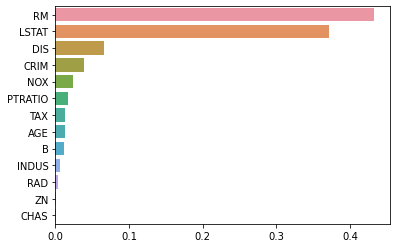

In [19]:
# 회귀 트리 Regressor는 coef_ 속성은 없지만 feature_importances_를 이용, 피처별 중요도는 확인 가능
import seaborn as sns

rf_reg = RandomForestRegressor(n_estimators=1000)

rf_reg.fit(X_data, y_target)

feature_series = pd.Series(data=rf_reg.feature_importances_, index=X_data.columns)
feature_series = feature_series.sort_values(ascending=False)
sns.barplot(x=feature_series, y=feature_series.index)

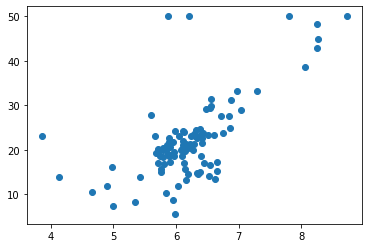

In [21]:
# 회귀 트리 Regressor가 어떻게 예측값을 판단하는지 선형회귀와 비교해서 시각화해보면
bostonDF_sample = bostonDF[['RM', 'PRICE']]
bostonDF_sample = bostonDF_sample.sample(n=100, random_state=0) #100개만 샘플링
plt.figure()
plt.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE)

In [27]:
from sklearn.linear_model import LinearRegression

#선형회귀와 max_depth가 각각 2, 7인 의사결정트리 생성
lr_reg = LinearRegression()
rf_reg2 = DecisionTreeRegressor(max_depth= 2)
rf_reg7 = DecisionTreeRegressor(max_depth= 7)

#테스트용 데이터를 임의로 생성
X_test = np.arange(4.5, 8.5, 0.04).reshape(-1,1)

X_features = bostonDF_sample.RM.values.reshape(-1,1) # Test 데이터와 데이터형식 맞춰주기
y_target = bostonDF_sample.PRICE.values.reshape(-1,1)

lr_reg.fit(X_features, y_target)
rf_reg2.fit(X_features, y_target)
rf_reg7.fit(X_features, y_target)

pred_lf = lr_reg.predict(X_test)
pred_rf2 = rf_reg2.predict(X_test)
pred_rf7 = rf_reg7.predict(X_test)


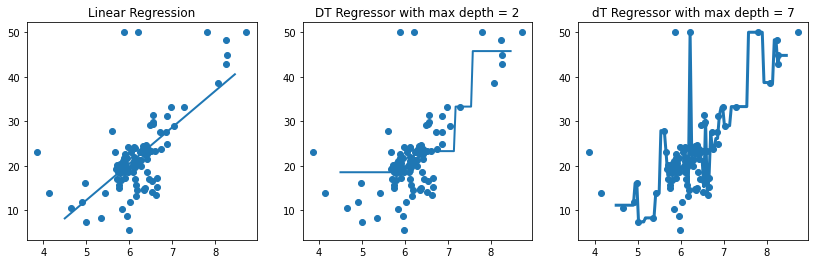

In [29]:
#회귀선을 그려보면
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(14,4), ncols=3)

ax1.set_title('Linear Regression')
ax1.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE)
ax1.plot(X_test, pred_lf, label='linear', linewidth=2)

ax2.set_title('DT Regressor with max depth = 2')
ax2.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE)
ax2.plot(X_test, pred_rf2, label='max_depth=2', linewidth=2)

ax3.set_title('dT Regressor with max depth = 7')
ax3.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE)
ax3.plot(X_test, pred_rf7, label = 'max_depth=7', linewidth=3) #max_depth = 7인 경우 과대적합이 되었음을 확인

In [1]:
'''
IX. 회귀 실습 - 자전거 대여 수요 예측
    - https://www.kaggle.com/c/bike-sharing-demand/data
    - 2011년 1월부터 2012년 12월까지 날짜/시간, 기온, 습도, 풍속 등의 정보를 기반으로 1시간 간격 동안의 자전거 대여 횟수가 기재, target은 count 칼럼
    - 성능 예측 방법은 RMSLE(Root Mean Squared Log Error)
'''

#데이터 가공

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

bike_df = pd.read_csv('train_bike.csv')
print(bike_df.shape)
bike_df.head()

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [2]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [3]:
# datetime 문자열을 datetime 타입으로 변환
bike_df['datetime'] = bike_df.datetime.apply(pd.to_datetime)

#datetime 타입에서 년, 월, 일, 시간 추출
bike_df['year'] = bike_df.datetime.apply(lambda x : x.year)
bike_df['month'] = bike_df.datetime.apply(lambda x : x.month)
bike_df['day'] = bike_df.datetime.apply(lambda x : x.day)
bike_df['hour'] = bike_df.datetime.apply(lambda x : x.hour)
bike_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4


In [4]:
# 사전에 등록되지 않은/된 대여횟수인 casual, registered는 쓸모없으므로(혹은 causal + registered =  count라서 target의 일부) 삭제
# datetime도 삭제
bike_df.drop(['datetime', 'casual', 'registered'], axis=1, inplace = True)

# 캐글에서 요구한 성능 예측방법인 RSMLE는 사이킷런에서 제공되지 않으므로 직접 함수로 생성해보면(MSE 등도 같이 함수로 생성)

from sklearn.metrics import mean_squared_error, mean_absolute_error

#log 값 변환시 log() 대신 log1p() 이용 -> NaN 문제 예방, 다시 원래값으로 변환할 떄는 expm1() 이용
def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred)**2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

#사이킷런의 mean_squared_log_error는 오버플로/언더플로 오류를 발생시킬 수도 있으므로 사용 지양
#import sklearn.metrics import mean_squared_log_error

def rmse(y, pred):
    return np.sqrt(mean_squared_error(y,pred))

#MAE, RMSE, RMSLE 모두 계산
def evaluate_regr(y, pred):
    rmsle_val = rmsle(y, pred)
    rmse_val = rmse(y, pred)
    mae_val = mean_absolute_error(y, pred)
    print('RMSLE : {}, RMSE : {}, MAE : {}'.format(rmsle_val, rmse_val, mae_val))


<AxesSubplot:>

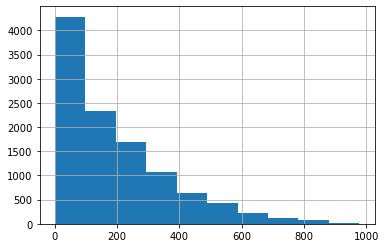

In [5]:
#로그변환, 피처 인코딩과 모델 학습/예측/평가
#데이터에 왜곡이 있는 경우 로그 변환을 통해 왜곡을 줄여주기 + 판다스의 get_dummies()를 이용해 카테고리형 변수는 더미변수(원핫인코딩)으로 변환해주기

from sklearn.model_selection import train_test_split, GridSearchCV

y_target = bike_df['count']
X_features = bike_df.drop('count', axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3)

#타겟 데이터 왜곡 확인
y_target.hist()

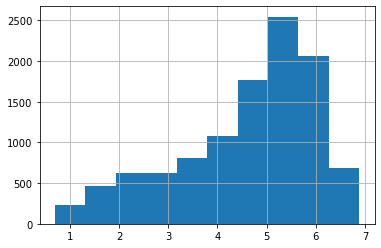

In [6]:
#로그 변환
y_target_log = np.log1p(y_target)

y_target_log.hist() #여기서 직접 해보진 않았지만 왜곡이 줄어들면 일반적으로 평가값들은 개선

#로그 변화된 데이터로 다시 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log, test_size = 0.3)


In [11]:
# 카테고리형 피처들을 더미변수로 만들면(여기서 보이지는 않았지만 더미변수로 만들지 않고 그냥 회귀분석을 하면 coefficient가 왜곡됨)
X_features_ohe = pd.get_dummies(X_features, columns = ['year','month','day','hour','holiday','workingday','season','weather']) #더미변수가 생성되는 만큼 칼럼은 증가함

# 로그변환 + 원핫인코딩 변수로 다시 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_target_log, test_size = 0.3)

#모델과 학습/테스트 데이터를 입력하면 성능 평가 수치를 반환하는 함수 생성
def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    if is_expm1:
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    print('####', model.__class__.__name__,'####')
    evaluate_regr(y_test, pred)
    
#모델별로 평가수행
from sklearn.linear_model import LinearRegression, Ridge, Lasso
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.01)

for model in [lr_reg, ridge_reg, lasso_reg]:
    get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=True)


#### LinearRegression ####
RMSLE : 0.5924550036661124, RMSE : 94.72705936287764, MAE : 61.0158134840412
#### Ridge ####
RMSLE : 0.5942355615575171, RMSE : 95.54718638762584, MAE : 61.424308628078116
#### Lasso ####
RMSLE : 0.6366132441117034, RMSE : 108.29290187055781, MAE : 68.97038353081305


<AxesSubplot:>

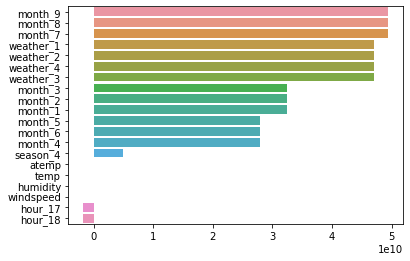

In [12]:
#회귀 계수 상위 25개 피처를 추출해보면
import seaborn as sns
coef = pd.Series(lr_reg.coef_, index=X_features_ohe.columns)
coef_sort = coef.sort_values(ascending=False)[:20]
sns.barplot(x=coef_sort.values, y=coef_sort.index) #월 변수, 공휴일인지 아닌지 의미하는 workingday변수의 coefficient가 큰 걸로 나옴

In [10]:
# 회귀 트리를 이용해 회귀 예측을 해 보면
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

#평가수행
rf_reg = RandomForestRegressor(n_estimators=500)
gbm_reg = GradientBoostingRegressor(n_estimators=500)
xgb_reg = XGBRegressor(n_estimators=500)
lgbm_reg = LGBMRegressor(n_estimators=500)

for model in [rf_reg, gbm_reg, xgb_reg, lgbm_reg]:
    # XGBoost의 경우 DataFrame이 입력될 경우 오류가 발생할 수도 있으므로 ndarray로 변환해주기
    get_model_predict(model, X_train.values, X_test.values, y_train.values, y_test.values, is_expm1=True)

# 성능이 개선되었음을 확인(항상 이런것은 X)
# XGBoost에서 Warning이 발생하는 것은 무시해도 됨

#### RandomForestRegressor ####
RMSLE : 0.3514935994757261, RMSE : 51.398459691093926, MAE : 30.4412245881232
#### GradientBoostingRegressor ####
RMSLE : 0.34154287293525565, RMSE : 52.57459180241224, MAE : 32.664077637548154
[00:54:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
#### XGBRegressor ####
RMSLE : 0.33758521579081435, RMSE : 50.993407475665066, MAE : 31.62539534012525
#### LGBMRegressor ####
RMSLE : 0.3229945787361966, RMSE : 49.232995971051636, MAE : 28.51805420716384


In [1]:
'''
X. 회귀 실습 - 캐글 주택 가격 : 고급회귀기법
    - https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data
    - RMSLE 기반
'''

#데이터 사전 처리
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

warnings.filterwarnings('ignore')

house_df_org = pd.read_csv('train_advanced.csv')
house_df = house_df_org.copy()
house_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [2]:
print(house_df.shape,'\n')
print(house_df.dtypes.value_counts,'\n')
isnull_series = house_df.isnull().sum()
print('Null 칼럼과 그 건 수\n', isnull_series[isnull_series>0].sort_values(ascending=False))

(1460, 81) 

<bound method IndexOpsMixin.value_counts of Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object> 

Null 칼럼과 그 건 수
 PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64


<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

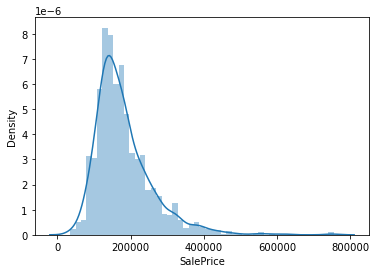

In [3]:
#타깃 값의 분포확인
sns.distplot(house_df['SalePrice'])

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

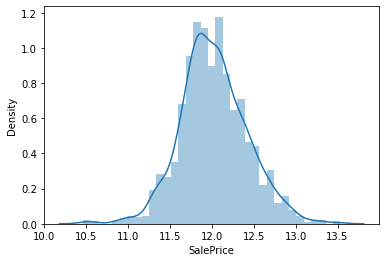

In [4]:
#왜곡 조정을 위해 로그변환시행
log_SalePrice = np.log1p(house_df['SalePrice'])
sns.distplot(log_SalePrice)

In [5]:
#로그변환한 타깃값을 데이터프레임에 반영 + Null값 조정

house_df['SalePrice'] = np.log1p(house_df['SalePrice'])

#Null이 많은 칼럼과 불필요한 칼럼 삭제
house_df.drop(['Id','PoolQC','MiscFeature','Alley','Fence','FireplaceQu'], axis=1, inplace=True)

#드롭하지 않은 Null 칼럼은 평균값으로 대체 -> 이제 문자형 피처만 Null값이 존재
house_df.fillna(house_df.mean(), inplace=True)

#문자형 피처는 pd.get_dummies()를 이용해 원핫인코딩으로 변환 -> get_dummies()는 Null값을 자동으로 None 칼럼으로 대체해주기 때문에 별도의 작업 필요 X
house_df_ohe = pd.get_dummies(house_df)

In [6]:
house_df_ohe.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,0,0,1,0,0,0,0,1,0
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,0,0,0,1,0,0,0,0,1,0
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,0,0,1,0,0,0,0,1,0
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,0,0,1,1,0,0,0,0,0
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,0,0,0,1,0,0,0,0,1,0


In [29]:
#선형 회귀 모델 학습/예측/평가

#여기서 타깃값은 이미 로그 변환이 되었으므로 예측 결과 오류에 RSME만 적용하면 자동으로 RMSLE측정 (위에서는 is_expm1 = True옵션이 있었기 때문에 로그 변환 -> 원본 변환 -> 다시 로그로 변환해서 RMSLE 측정의 과정을 거치게 된것, 따라서 is_expm1= False로 하면 로그변환이 중복되기때문에 하면 안될듯)
from sklearn.metrics import mean_squared_error

def get_rmse(model):
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    rmse = np.mean(mse)
    print(model.__class__.__name__, '로그 변환된 RMSE :', np.round(rmse,3))
    return rmse

def get_rmses(models):
    rmses = []
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
    
    return rmses

#선형회귀모델 학습, 예측 ,평가
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice',axis=1,inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

LinearRegression 로그 변환된 RMSE : 0.027
Ridge 로그 변환된 RMSE : 0.021
Lasso 로그 변환된 RMSE : 0.033


[0.027038618353590414, 0.021028565697508356, 0.032525594990253]

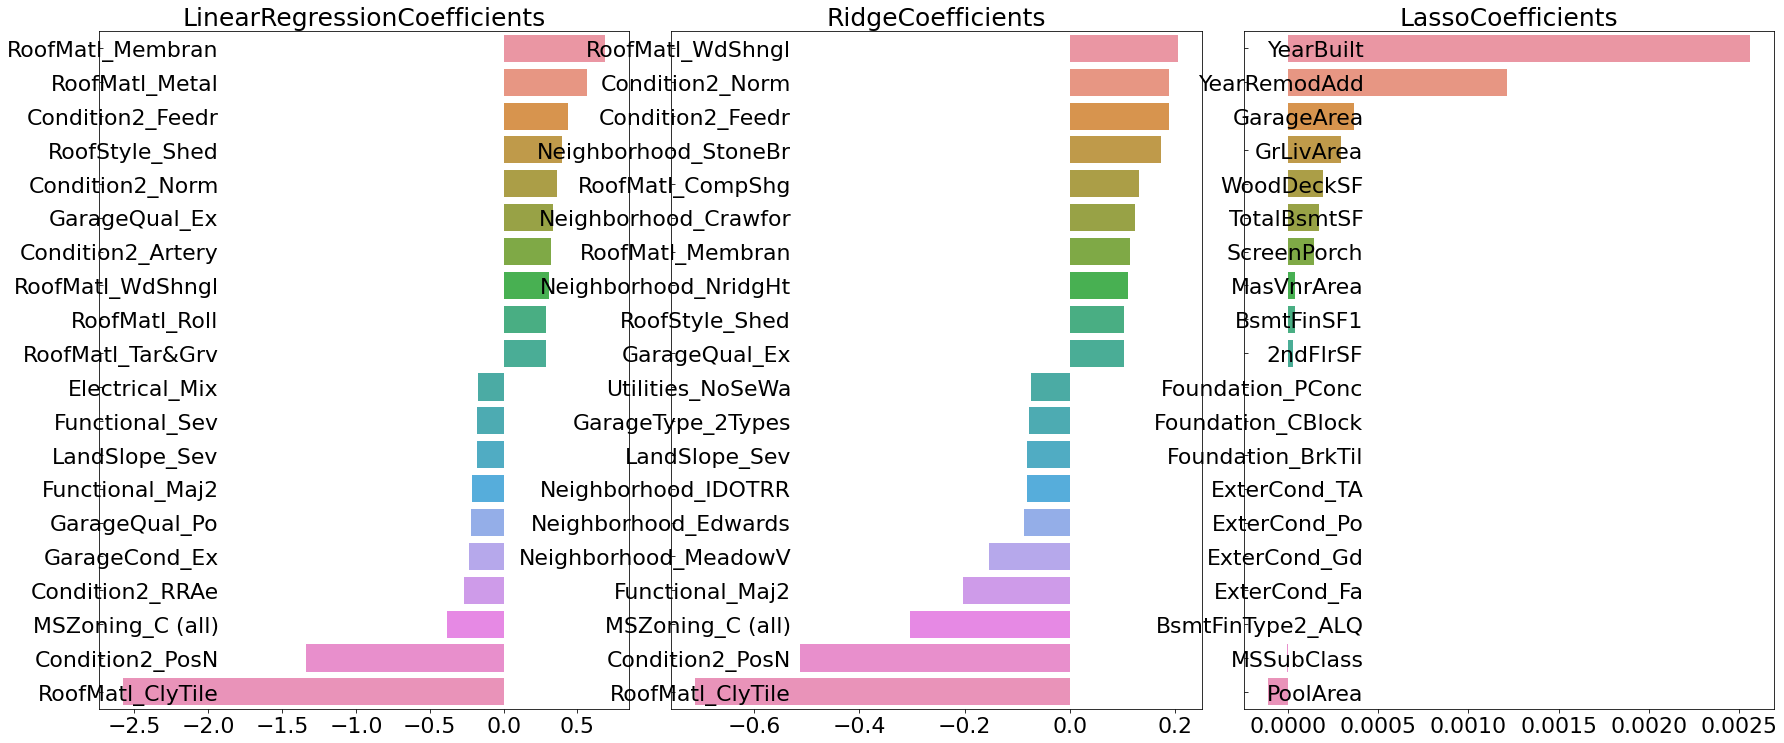

In [33]:
#피처별 회귀계수 시각화(상위,하위 10개)

def get_top_bottom_coef(model, n=10): #상위,하위 10개 추출하는 함수
    coef = pd.Series(model.coef_, index=X_features.columns)
    
    #상위,하위 10개 회귀계수 추출해 반환
    coef_high = coef.sort_values(ascending=False).head(n)
    coef_low = coef.sort_values(ascending=False).tail(n)
    return coef_high, coef_low

def visualize_coefficient(models): #시각화
    #3개모델의 시각화를 위해 3개의 칼럼을 가지는 subplot생성
    fig, axs = plt.subplots(figsize=(24,10), nrows=1, ncols=3)
    fig.tight_layout()
    
    for i_num, model in enumerate(models):
        coef_high, coef_low = get_top_bottom_coef(model, n=10)
        coef_concat = pd.concat([coef_high, coef_low]) #concat으로 시리즈 결합
        #ax subplot에 barchar로 표현, 한 화면에 표현하기 위한 tick label 위치와 font 크기 조정
        axs[i_num].set_title(model.__class__.__name__ + 'Coefficients', size=25)
        axs[i_num].tick_params(axis='y', direction='in',pad=-120)
        
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=coef_concat.values, y=coef_concat.index, ax=axs[i_num])
        
#모델 회귀계수 시각화
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

In [43]:
# 결과를 보면 OLS 기반의 릿지와 선형회귀는 회귀계수가 유사한데 라쏘는 그렇지 못함
# 학습 데이터의 분할의 문제인지 확인하기 위해 전체 데이터 세트를 이용, 5 폴드 교차검증 시행
from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models):
    for model in models:
        # 분할하지 않고 전체 데이터로 cross_val_score( ) 수행. 모델별 CV RMSE값과 평균 RMSE 출력
        rmse_list = np.sqrt(-cross_val_score(model, X_features, y_target,
                                             scoring="neg_mean_squared_error", cv = 6))
        rmse_avg = np.mean(rmse_list)
        print('\n{0} CV RMSE 값 리스트: {1}'.format( model.__class__.__name__, np.round(rmse_list, 3)))
        print('{0} CV 평균 RMSE 값: {1}'.format( model.__class__.__name__, np.round(rmse_avg, 3)))

# 앞 예제에서 학습한 lr_reg, ridge_reg, lasso_reg 모델의 CV RMSE값 출력           
models = [lr_reg, ridge_reg, lasso_reg]
get_avg_rmse_cv(models)
#여전히 Lasso의 성능이 뒤떨어짐


LinearRegression CV RMSE 값 리스트: [0.126 0.133 0.173 0.158 0.102 0.214]
LinearRegression CV 평균 RMSE 값: 0.151

Ridge CV RMSE 값 리스트: [0.119 0.125 0.166 0.132 0.11  0.204]
Ridge CV 평균 RMSE 값: 0.142

Lasso CV RMSE 값 리스트: [0.164 0.175 0.219 0.175 0.17  0.279]
Lasso CV 평균 RMSE 값: 0.197


In [40]:
#릿지와 라쏘모델 하이퍼 파라미터 튜닝
from sklearn.model_selection import GridSearchCV

def print_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params, 
                              scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X_features, y_target)
    rmse = np.sqrt(-1* grid_model.best_score_)
    print('{0} 5 CV 시 최적 평균 RMSE 값: {1}, 최적 alpha:{2}'.format(model.__class__.__name__,
                                        np.round(rmse, 4), grid_model.best_params_))
    return grid_model.best_estimator_

ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
best_rige = print_best_params(ridge_reg, ridge_params)
best_lasso = print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값: 0.1418, 최적 alpha:{'alpha': 12}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.142, 최적 alpha:{'alpha': 0.001}


LinearRegression 로그 변환된 RMSE : 0.027
Ridge 로그 변환된 RMSE : 0.019
Lasso 로그 변환된 RMSE : 0.017


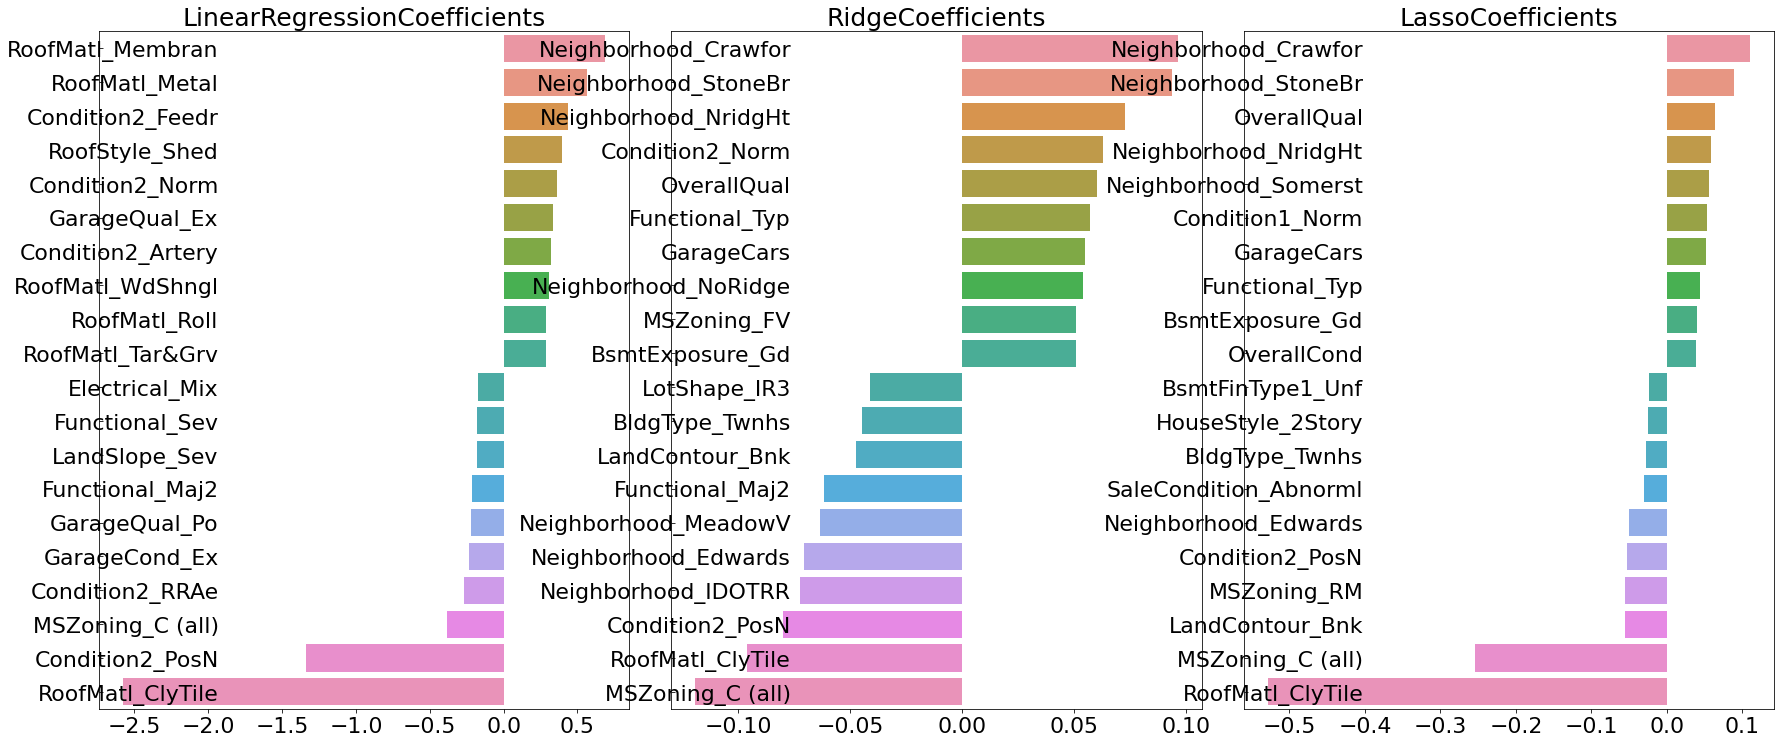

In [44]:
# 앞의 최적화 alpha값으로 학습데이터로 학습, 테스트 데이터로 예측 및 평가 수행. 
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=12)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화 
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

#튜닝 후 예측성능이 향상됨, 라쏘 모델의 결과도 릿지, 선형회귀와 결과가 유사

In [45]:
# 이상치 처리를 통한 모델 튜닝
# 사이파이 stats 모듈의 skew() 함수를 이용, 칼럼의 왜곡도 확인, 일반적으로 1 이상일 때 왜곡도가 높다고 판단, 1 이상인 데이터 피처에 대해 로그 변환 시행

from scipy.stats import skew

# object가 아닌 숫자형 피쳐의 컬럼 index 객체 추출.
features_index = house_df.dtypes[house_df.dtypes != 'object'].index
# house_df에 컬럼 index를 [ ]로 입력하면 해당하는 컬럼 데이터 셋 반환. apply lambda로 skew( )호출 
skew_features = house_df[features_index].apply(lambda x : skew(x))
# skew 정도가 1 이상인 컬럼들만 추출. 
skew_features_top = skew_features[skew_features > 1]
print(skew_features_top.sort_values(ascending=False))

MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.673661
LotFrontage       2.382499
OpenPorchSF       2.361912
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
MSSubClass        1.406210
1stFlrSF          1.375342
GrLivArea         1.365156
dtype: float64


In [47]:
#추출된 피처를 로그 변환
house_df[skew_features_top.index] =  np.log1p(house_df[skew_features_top.index])

In [48]:
# Skew가 높은 피처들을 로그 변환 했으므로 다시 원-핫 인코딩 적용 및 피처/타겟 데이터 셋 생성,
house_df_ohe = pd.get_dummies(house_df)
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice',axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

# 피처들을 로그 변환 후 다시 최적 하이퍼 파라미터와 RMSE 출력
ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
best_ridge = print_best_params(ridge_reg, ridge_params)
best_lasso = print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값: 0.1275, 최적 alpha:{'alpha': 10}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.1252, 최적 alpha:{'alpha': 0.001}


LinearRegression 로그 변환된 RMSE : 0.016
Ridge 로그 변환된 RMSE : 0.015
Lasso 로그 변환된 RMSE : 0.014


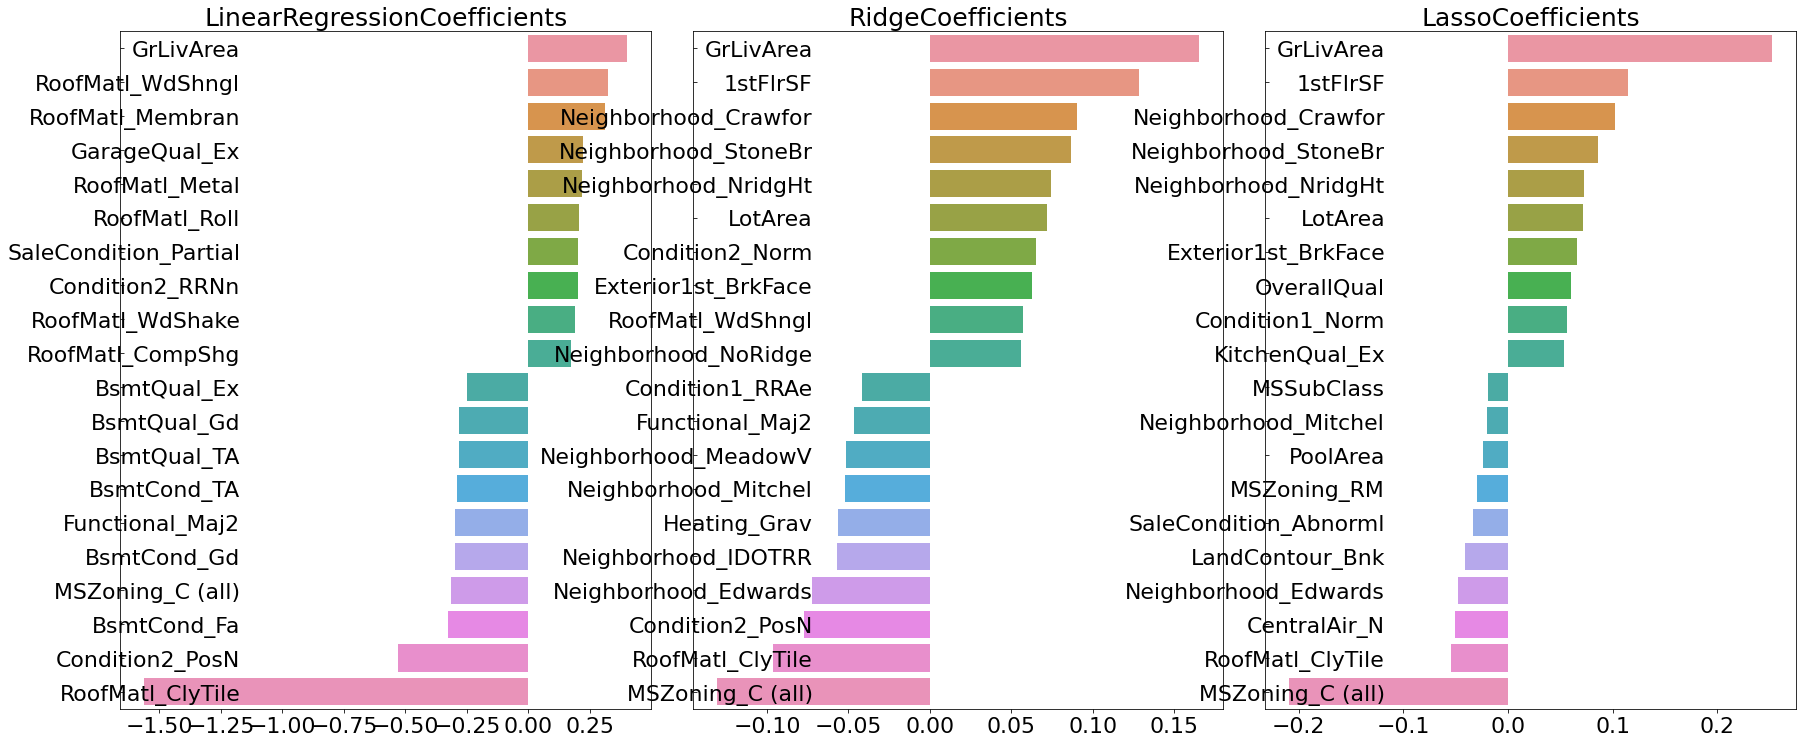

In [49]:
# 앞의 최적화 alpha값으로 학습데이터로 학습, 테스트 데이터로 예측 및 평가 수행. 
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=10)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화 
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

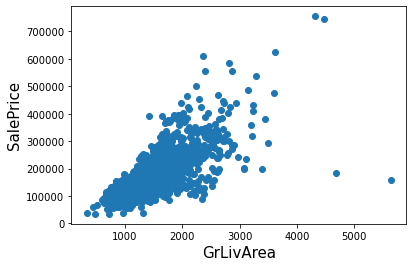

In [50]:
# 가장 영향력이 큰 피처인 GrLivArea(주거 공간 크기)의 outlier확인

plt.scatter(x = house_df_org['GrLivArea'], y = house_df_org['SalePrice'])
plt.ylabel('SalePrice', fontsize=15)
plt.xlabel('GrLivArea', fontsize=15)
plt.show() #오른쪽 밑에 outlier 확인

In [51]:
#GrLivArea가 4000평방피트 이상임에도 가격이 500,000 달러 이하인 데이터는 모두 이상치로 간주하고 삭제
# GrLivArea와 SalePrice 모두 로그 변환되었으므로 이를 반영한 조건 생성. 
cond1 = house_df_ohe['GrLivArea'] > np.log1p(4000)
cond2 = house_df_ohe['SalePrice'] < np.log1p(500000)
outlier_index = house_df_ohe[cond1 & cond2].index

print('아웃라이어 레코드 index :', outlier_index.values)
print('아웃라이어 삭제 전 house_df_ohe shape:', house_df_ohe.shape)
# DataFrame의 index를 이용하여 아웃라이어 레코드 삭제. 
house_df_ohe.drop(outlier_index , axis=0, inplace=True)
print('아웃라이어 삭제 후 house_df_ohe shape:', house_df_ohe.shape)

아웃라이어 레코드 index : [ 523 1298]
아웃라이어 삭제 전 house_df_ohe shape: (1460, 271)
아웃라이어 삭제 후 house_df_ohe shape: (1458, 271)


In [52]:
#다시 교차검증
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice',axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
best_ridge = print_best_params(ridge_reg, ridge_params)
best_lasso = print_best_params(lasso_reg, lasso_params)

#아웃라이어를 제거했을 때 예측 수치가 크게 향상된 것을 확인
#타깃에 큰 영향을 미치는 피처의 이상치를 탐지하는 노력은 중요

Ridge 5 CV 시 최적 평균 RMSE 값: 0.1125, 최적 alpha:{'alpha': 8}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.1122, 최적 alpha:{'alpha': 0.001}


LinearRegression 로그 변환된 RMSE : 0.017
Ridge 로그 변환된 RMSE : 0.011
Lasso 로그 변환된 RMSE : 0.01


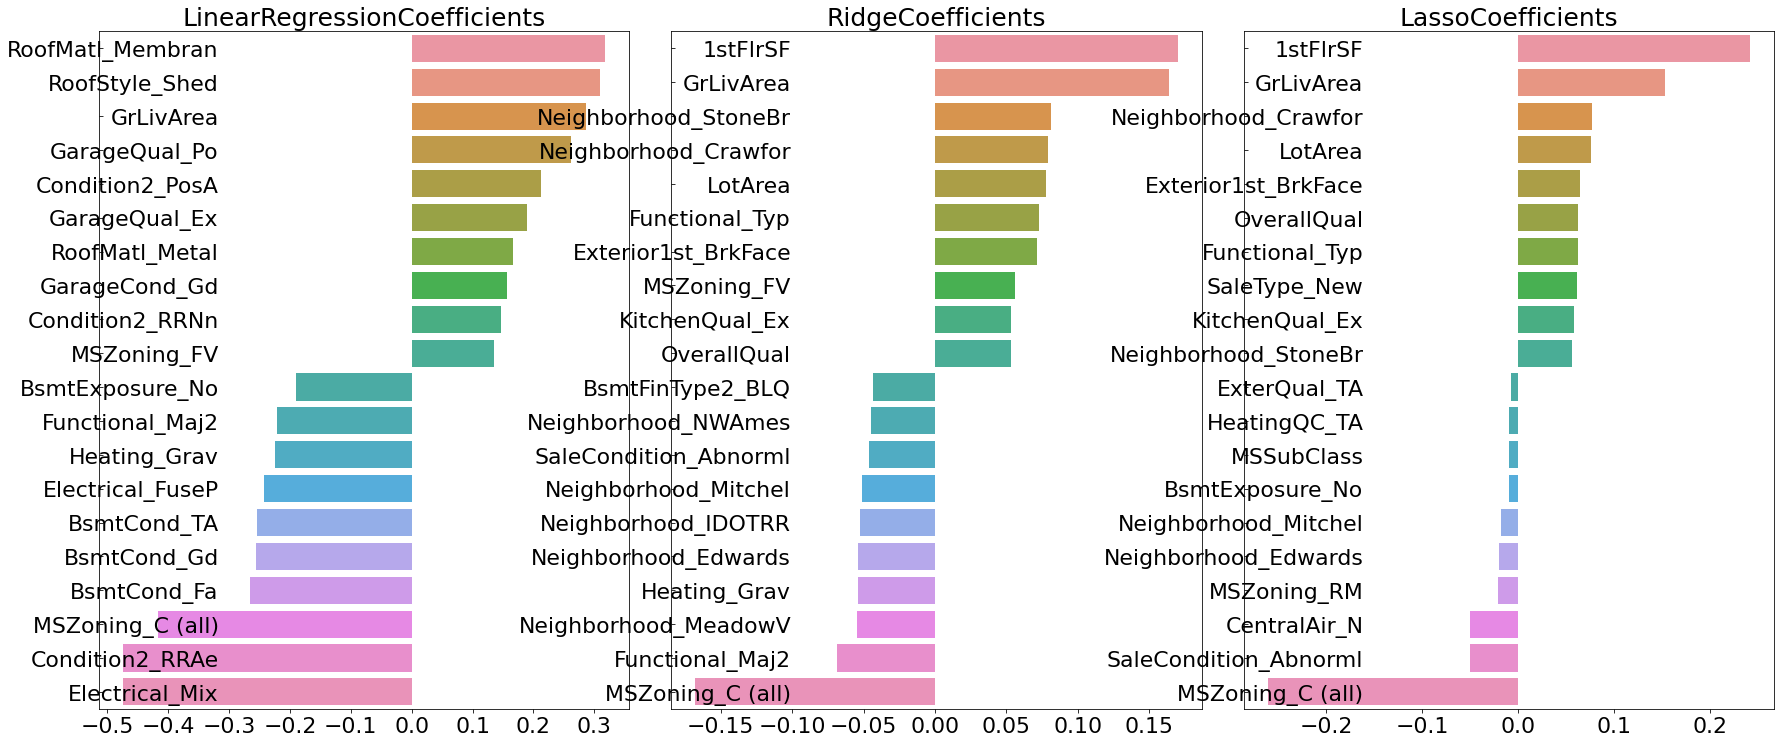

In [53]:
#이상치 제거 후 학습 및 시각화

# 앞의 최적화 alpha값으로 학습데이터로 학습, 테스트 데이터로 예측 및 평가 수행. 
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화 
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

In [54]:
#회귀 트리 모델 학습/예측/평가
#XGBoost와 LightGBM Regressor이용

from xgboost import XGBRegressor

xgb_params = {'n_estimators':[1000]}
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, 
                       colsample_bytree=0.5, subsample=0.8)
best_xgb = print_best_params(xgb_reg, xgb_params)


from lightgbm import LGBMRegressor

lgbm_params = {'n_estimators':[1000]}
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, 
                         subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
best_lgbm = print_best_params(lgbm_reg, lgbm_params)

[01:58:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:58:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:59:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:59:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:59:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:59:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor 5 CV 시 최적 평균 RMSE 값: 0.115, 최적 alpha:{'n_estimators': 1000}
LGBMRegressor 5 CV 시 최적 평균 RMSE 값: 0.1163, 최적 alpha:{'n_estimators': 1000}


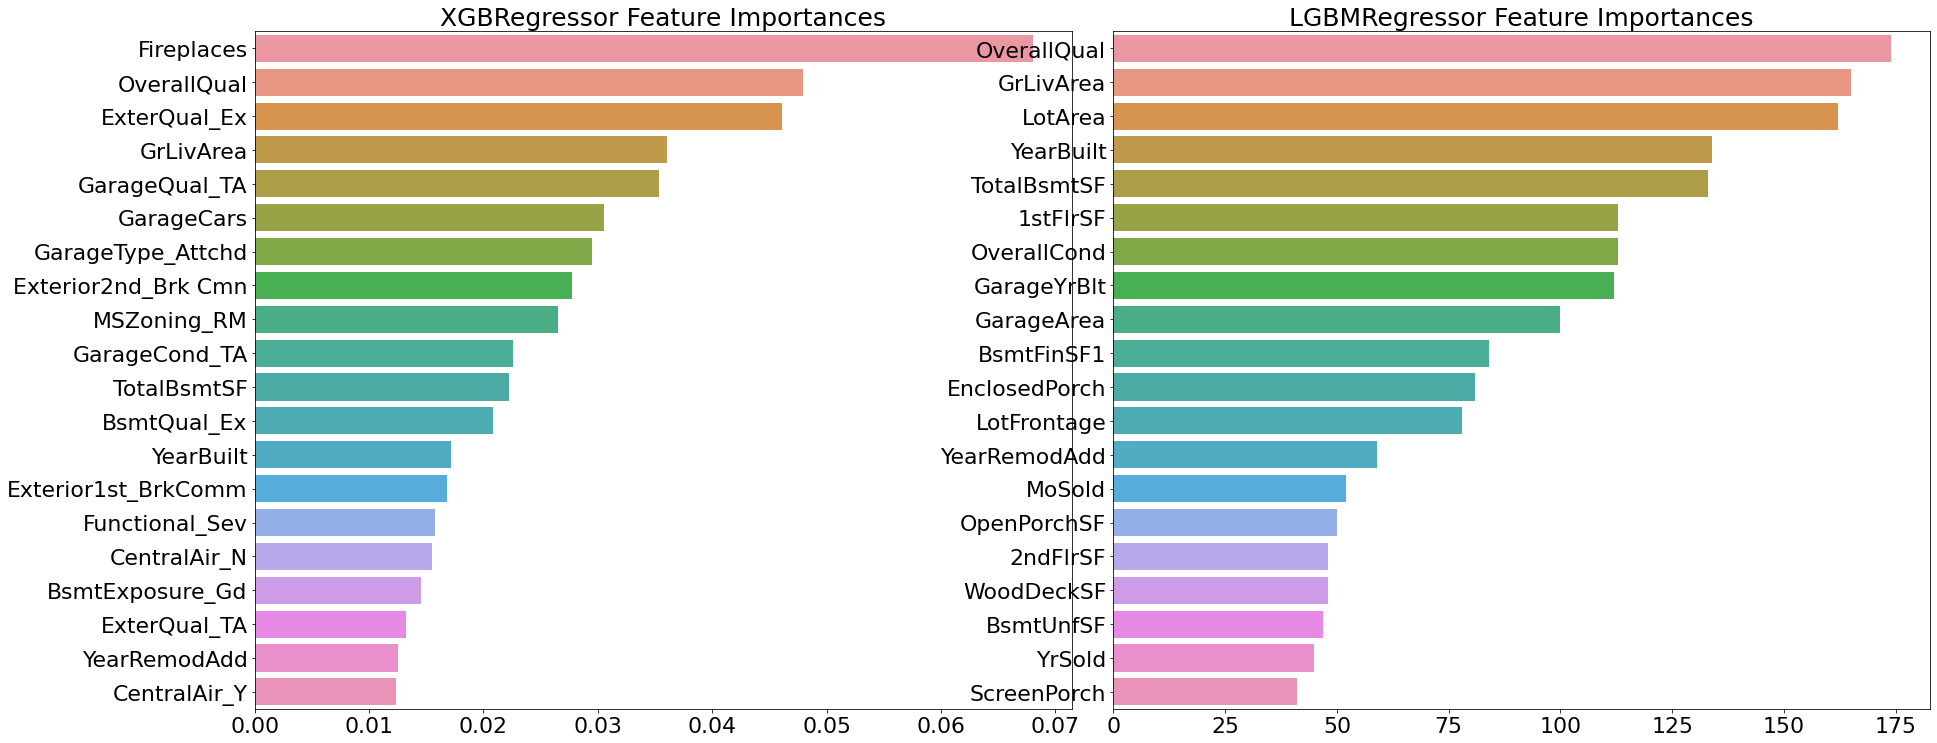

In [55]:
# 피처 중요도 시각화
# 모델의 중요도 상위 20개의 피처명과 그때의 중요도값을 Series로 반환.
def get_top_features(model):
    ftr_importances_values = model.feature_importances_
    ftr_importances = pd.Series(ftr_importances_values, index=X_features.columns  )
    ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
    return ftr_top20

def visualize_ftr_importances(models):
    # 2개 회귀 모델의 시각화를 위해 2개의 컬럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24,10),nrows=1, ncols=2)
    fig.tight_layout() 
    # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 피처 중요도 시각화. 
    for i_num, model in enumerate(models):
        # 중요도 상위 20개의 피처명과 그때의 중요도값 추출 
        ftr_top20 = get_top_features(model)
        axs[i_num].set_title(model.__class__.__name__+' Feature Importances', size=25)
        #font 크기 조정.
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=ftr_top20.values, y=ftr_top20.index , ax=axs[i_num])

# 앞 예제에서 print_best_params( )가 반환한 GridSearchCV로 최적화된 모델의 피처 중요도 시각화    
models = [best_xgb, best_lgbm]
visualize_ftr_importances(models)


In [56]:
#회귀모델의 예측결과 혼합을 통한 최종 예측
#예측결과 혼합은 말 그대로 A 모델의 예측값을 a만큼, B모델의 예측값을 1-a만큼 반영하는 것

#최종 혼합모델, 개별모델의 RMSE 값을 출력하는 get_rmse_pred()함수 생성
def get_rmse_pred(preds):
    for key in preds.keys():
        pred_value = preds[key]
        mse = mean_squared_error(y_test , pred_value)
        rmse = np.sqrt(mse)
        print('{0} 모델의 RMSE: {1}'.format(key, rmse))

# 개별 모델의 학습
ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)
# 개별 모델 예측
ridge_pred = ridge_reg.predict(X_test)
lasso_pred = lasso_reg.predict(X_test)

# 개별 모델 예측값 혼합으로 최종 예측값 도출
pred = 0.4 * ridge_pred + 0.6 * lasso_pred #가중치를 정하는 특별한 기준이 있는 것은 X
preds = {'최종 혼합': pred,
         'Ridge': ridge_pred,
         'Lasso': lasso_pred}
#최종 혼합 모델, 개별모델의 RMSE 값 출력
get_rmse_pred(preds)

#혼합모델에서 성능이 향상된 것을 확인

최종 혼합 모델의 RMSE: 0.10007930884470512
Ridge 모델의 RMSE: 0.10345177546603253
Lasso 모델의 RMSE: 0.1002417046089003


In [57]:
#이번에는 XGBoost와 LightGBM 회귀모델 혼합
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, 
                       colsample_bytree=0.5, subsample=0.8)
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, 
                         subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
xgb_reg.fit(X_train, y_train)
lgbm_reg.fit(X_train, y_train)
xgb_pred = xgb_reg.predict(X_test)
lgbm_pred = lgbm_reg.predict(X_test)

pred = 0.5 * xgb_pred + 0.5 * lgbm_pred
preds = {'최종 혼합': pred,
         'XGBM': xgb_pred,
         'LGBM': lgbm_pred}
        
get_rmse_pred(preds)

#혼합모델에서 성능이 향상된 것을 확인

[02:02:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
최종 혼합 모델의 RMSE: 0.0999551123128891
XGBM 모델의 RMSE: 0.10075115846547565
LGBM 모델의 RMSE: 0.10382510019327311


In [58]:
#스태킹 앙상블 모델을 통한 회귀 예측

#개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수 생성
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수. 
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds ):
    # 지정된 n_folds값으로 KFold 생성.
    kf = KFold(n_splits=n_folds, shuffle=False, random_state=0)
    #추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화 
    train_fold_pred = np.zeros((X_train_n.shape[0] ,1 ))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__ , ' model 시작 ')
    
    for folder_counter , (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 셋 추출 
        print('\t 폴드 세트: ',folder_counter,' 시작 ')
        X_tr = X_train_n[train_index] 
        y_tr = y_train_n[train_index] 
        X_te = X_train_n[valid_index]  
        
        #폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행.
        model.fit(X_tr , y_tr)       
        #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        #입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장. 
        test_pred[:, folder_counter] = model.predict(X_test_n)
            
    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성 
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)    
    
    #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred , test_pred_mean

In [59]:
#릿지, 라쏘, XGBoost, LightGBM을 개별모델로 해서 학습용, 테스트용 데이터 반환
# get_stacking_base_datasets( )은 넘파이 ndarray를 인자로 사용하므로 DataFrame을 넘파이로 변환. 
X_train_n = X_train.values
X_test_n = X_test.values
y_train_n = y_train.values

# 각 개별 기반(Base)모델이 생성한 학습용/테스트용 데이터 반환. 
ridge_train, ridge_test = get_stacking_base_datasets(ridge_reg, X_train_n, y_train_n, X_test_n, 5)
lasso_train, lasso_test = get_stacking_base_datasets(lasso_reg, X_train_n, y_train_n, X_test_n, 5)
xgb_train, xgb_test = get_stacking_base_datasets(xgb_reg, X_train_n, y_train_n, X_test_n, 5)  
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_reg, X_train_n, y_train_n, X_test_n, 5)

Ridge  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
Lasso  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
XGBRegressor  model 시작 
	 폴드 세트:  0  시작 
[02:05:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	 폴드 세트:  1  시작 
[02:05:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	 폴드 세트:  2  시작 
[02:05:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	 폴드 세트:  3  시작 
[02:06:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	 폴드 세트:  4  시작 
[02:06:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
LGBMRegressor  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시

In [60]:
#최종메타모델에 적용
# 개별 모델이 반환한 학습 및 테스트용 데이터 세트를 Stacking 형태로 결합.  
Stack_final_X_train = np.concatenate((ridge_train, lasso_train, 
                                      xgb_train, lgbm_train), axis=1)
Stack_final_X_test = np.concatenate((ridge_test, lasso_test, 
                                     xgb_test, lgbm_test), axis=1)

# 최종 메타 모델은 라쏘 모델을 적용. 
meta_model_lasso = Lasso(alpha=0.0005)

#기반 모델의 예측값을 기반으로 새롭게 만들어진 학습 및 테스트용 데이터로 예측하고 RMSE 측정.
meta_model_lasso.fit(Stack_final_X_train, y_train)
final = meta_model_lasso.predict(Stack_final_X_test)
mse = mean_squared_error(y_test , final)
rmse = np.sqrt(mse)
print('스태킹 회귀 모델의 최종 RMSE 값은:', rmse)

스태킹 회귀 모델의 최종 RMSE 값은: 0.09738961783055014
